## Imports and Drive Mounting

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score
import tensorflow as tf
from google.colab import output
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import colorlover as cl
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
traffic_sign_labels = {0: '20 km/h',
1:'30 km/h',
2:'50 km/h',
3:'60 km/h',
4:'70 km/h',
5:'80 km/h',
6:'80 km/h end',
7:'100 km/h',
8:'120 km/h',
9:'No overtaking',
10:'No overtaking for trucks',
11:'Crossroad with secondary way',
12:'Main road',
13:'Give way',
14:'Stop',
15:'Road up',
16:'Road - trucks',
17:'No Entry',
18:'Other dangerous',
19:'Turn left',
20:'Turn right',
21:'Winding road',
22:'Hollow road',
23:'Slippery road',
24:'Narrowing road',
25:'Roadwork',
26:'Traffic light',
27:'Pedestrian',
28:'Children',
29:'Cycle',
30:'Snow',
31:'Deer',
32:'End of the limits',
33:'Only right',
34:'Only left',
35:'Only straight',
36:'Only straight and right',
37:'Only straight and left',
38:'Take right',
39:'Take left',
40:'Circle crossroad',
41:'End of overtaking limit',
42:'End of overtaking limit for track'
}

In [19]:
traffic_sign_labels_series = pd.Series(traffic_sign_labels)
traffic_sign_labels_series.head()

0    20 km/h
1    30 km/h
2    50 km/h
3    60 km/h
4    70 km/h
dtype: object

In [20]:
traffic_class_list = ["Class00", "Class01", "Class02", "Class03", "Class04", "Class05", "Class06", "Class07", "Class08", "Class09", 
 "Class10", "Class11", "Class12", "Class13", "Class14", "Class15", "Class16", "Class17", "Class18", "Class19", 
 "Class20", "Class21", "Class22", "Class23", "Class24", "Class25", "Class26", "Class27", "Class28", "Class29", 
 "Class30", "Class31", "Class32", "Class33", "Class34", "Class35", "Class36", "Class37", "Class38", "Class39", 
 "Class40", "Class41", "Class42"]

In [21]:
traffic_class_series = pd.Series(traffic_class_list)
traffic_class_series.head()

0    Class00
1    Class01
2    Class02
3    Class03
4    Class04
dtype: object

In [22]:
traffic_sign_labels_df = pd.concat([traffic_sign_labels_series, 
                                    traffic_class_series], 
                                   axis=1)
traffic_sign_labels_df.reset_index(inplace=True)
traffic_sign_labels_df.rename(columns = {0:'Original_Class_Names', 
                                         1: 'New_Class_Names',
                                         'index': 'Class_Name_Index'}, 
                              inplace = True)

traffic_sign_labels_df.head()

,Class_Name_Index,Original_Class_Names,New_Class_Names
0,0,20 km/h,Class00
1,1,30 km/h,Class01
2,2,50 km/h,Class02
3,3,60 km/h,Class03
4,4,70 km/h,Class04


In [23]:
new_dict = traffic_sign_labels_df['New_Class_Names'].to_dict()

In [24]:
new_dict

{0: 'Class00',
 1: 'Class01',
 2: 'Class02',
 3: 'Class03',
 4: 'Class04',
 5: 'Class05',
 6: 'Class06',
 7: 'Class07',
 8: 'Class08',
 9: 'Class09',
 10: 'Class10',
 11: 'Class11',
 12: 'Class12',
 13: 'Class13',
 14: 'Class14',
 15: 'Class15',
 16: 'Class16',
 17: 'Class17',
 18: 'Class18',
 19: 'Class19',
 20: 'Class20',
 21: 'Class21',
 22: 'Class22',
 23: 'Class23',
 24: 'Class24',
 25: 'Class25',
 26: 'Class26',
 27: 'Class27',
 28: 'Class28',
 29: 'Class29',
 30: 'Class30',
 31: 'Class31',
 32: 'Class32',
 33: 'Class33',
 34: 'Class34',
 35: 'Class35',
 36: 'Class36',
 37: 'Class37',
 38: 'Class38',
 39: 'Class39',
 40: 'Class40',
 41: 'Class41',
 42: 'Class42'}

In [4]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/DMML2/KaggleData

/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData


In [32]:
# Paths and parameters.

train_data_path = '../NumpyArrays/Cells.npy'
train_label_path = '../NumpyArrays/Labels.npy'
test_data_path = '../NumpyArrays/Cells_test.npy'
test_label_path = '../NumpyArrays/Labels_test.npy'
test_blur3_path = '../NumpyArrays/Cells_test_blur3.npy'
test_blur5_path = '../NumpyArrays/Cells_test_blur5.npy'
test_blur7_path = '../NumpyArrays/Cells_test_blur7.npy'
visualization_path = '/content/drive/My Drive/Colab Notebooks/DMML2/Visualisations'

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height*width*channels

# Model

In [6]:
# Loading Train Data.

Cells = np.load(train_data_path)
Labels = np.load(train_label_path)

In [7]:
# Randomize the order of the input images

s = np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells = Cells[s]
labels = Labels[s]

In [8]:
# Spliting the images into train and validation sets
(X_train, X_val) = Cells[(int)(0.2*len(labels)):], Cells[:(int)(0.2*len(labels))]

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

(y_train, y_val) = labels[(int)(0.2*len(labels)):], labels[:(int)(0.2*len(labels))]

In [9]:
# Using one hote encoding for the train and validation labels

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [10]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

#Load the VGG19 model
vgg_model = VGG19(input_shape = (75, 75, 3), 
                        include_top = False, 
                        weights = 'imagenet')

80142336/80134624 [==============================] - 0s 0us/step


In [11]:
for layer in vgg_model.layers:
     layer.trainable = False

# vgg_model.summary()

last_layer = vgg_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(43, activation='softmax')(x)           

vgg_new_model = Model(vgg_model.input, x) 

vgg_new_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
# vgg_new_model.summary()

last layer of vgg : output shape:  (None, 2, 2, 512)


In [12]:
#using ten epochs for the training and saving the accuracy for each epoch
%%time
epochs = 20
history = vgg_new_model.fit(X_train, y_train, batch_size=32, 
                        epochs=epochs, validation_data = (X_val, y_val))

Epoch 1/20
981/981 [==============================] - 50s 51ms/step - loss: 1.8783 - acc: 0.4744 - val_loss: 1.3704 - val_acc: 0.5983
Epoch 2/20
981/981 [==============================] - 50s 51ms/step - loss: 1.1878 - acc: 0.6531 - val_loss: 1.0294 - val_acc: 0.6980
Epoch 3/20
981/981 [==============================] - 50s 51ms/step - loss: 0.9314 - acc: 0.7280 - val_loss: 0.8583 - val_acc: 0.7496
Epoch 4/20
981/981 [==============================] - 50s 51ms/step - loss: 0.7806 - acc: 0.7680 - val_loss: 0.7563 - val_acc: 0.7748
Epoch 5/20
981/981 [==============================] - 49s 50ms/step - loss: 0.6742 - acc: 0.8016 - val_loss: 0.6761 - val_acc: 0.8008
Epoch 6/20
981/981 [==============================] - 49s 50ms/step - loss: 0.5956 - acc: 0.8220 - val_loss: 0.6143 - val_acc: 0.8081
Epoch 7/20
981/981 [==============================] - 50s 51ms/step - loss: 0.5360 - acc: 0.8413 - val_loss: 0.5654 - val_acc: 0.8258
Epoch 8/20
981/981 [==============================] - 49s 50ms

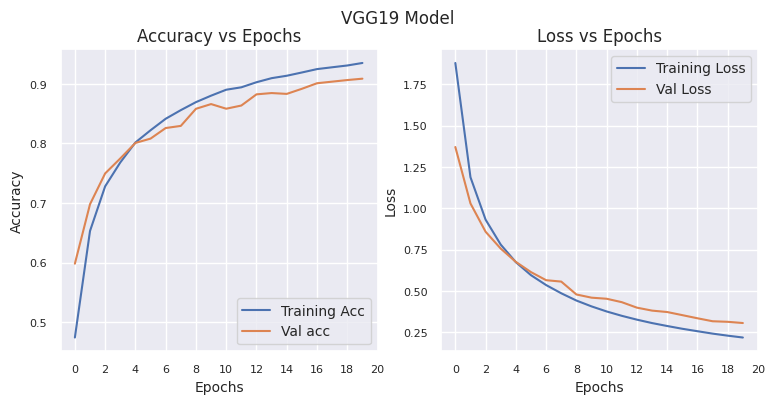

In [33]:
# Creating plots

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)
 
fig.suptitle("VGG19 Model", 
             fontdict = {'fontsize': 10, 'fontweight' : 3})
 
ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(history.history['acc'], label='Training Acc')
ax[0].plot(history.history['val_acc'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
 
ax[1].set_title('Loss vs Epochs')
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))

fig.savefig(os.path.join(visualization_path, 'VGG19_acc_loss.png'), 
            dpi=300, bbox_inches='tight')

In [15]:
# Loading test data from saved files.

# X_test = np.load(test_data_path)
# y_test = np.load(test_label_path)

# Loading test data from saved array files.
 
X_test = np.load(test_data_path)
X_test_3 = np.load(test_blur3_path)
X_test_5 = np.load(test_blur5_path)
X_test_7 = np.load(test_blur7_path)
y_test = np.load(test_label_path)

In [16]:
# X_test = X_test.astype('float32')/255 

X_test = X_test.astype('float32')/255 
X_test_3 = X_test_3.astype('float32')/255 
X_test_5 = X_test_5.astype('float32')/255 
X_test_7 = X_test_7.astype('float32')/255 

In [17]:
# Predicting output.

pred = vgg_new_model.predict(X_test)
# print(pred.shape)
pred_3 = vgg_new_model.predict(X_test_3)
pred_5 = vgg_new_model.predict(X_test_5)
pred_7 = vgg_new_model.predict(X_test_7)

In [25]:
from sklearn.metrics import classification_report
  
traffic_sign_labels_list = [new_dict[i] for i in range(len(new_dict))]

vgg_class = classification_report(y_test, np.argmax(pred, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

In [26]:
vgg_class_3 = classification_report(y_test, np.argmax(pred_3, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

In [27]:
vgg_class_5 = classification_report(y_test, np.argmax(pred_5, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

In [28]:
vgg_class_7 = classification_report(y_test, np.argmax(pred_7, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
vgg_df_top = pd.DataFrame(vgg_class).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg_df_top.reset_index(inplace=True)
vgg_df_bottom = pd.DataFrame(vgg_class).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg_df_bottom.reset_index(inplace=True)

vgg_df_top_3 = pd.DataFrame(vgg_class_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg_df_top_3.reset_index(inplace=True)
vgg_df_bottom_3 = pd.DataFrame(vgg_class_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg_df_bottom_3.reset_index(inplace=True)

vgg_df_top_5 = pd.DataFrame(vgg_class_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg_df_top_5.reset_index(inplace=True)
vgg_df_bottom_5 = pd.DataFrame(vgg_class_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg_df_bottom_5.reset_index(inplace=True)

vgg_df_top_7 = pd.DataFrame(vgg_class_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
vgg_df_top_7.reset_index(inplace=True)
vgg_df_bottom_7 = pd.DataFrame(vgg_class_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
vgg_df_bottom_7.reset_index(inplace=True)

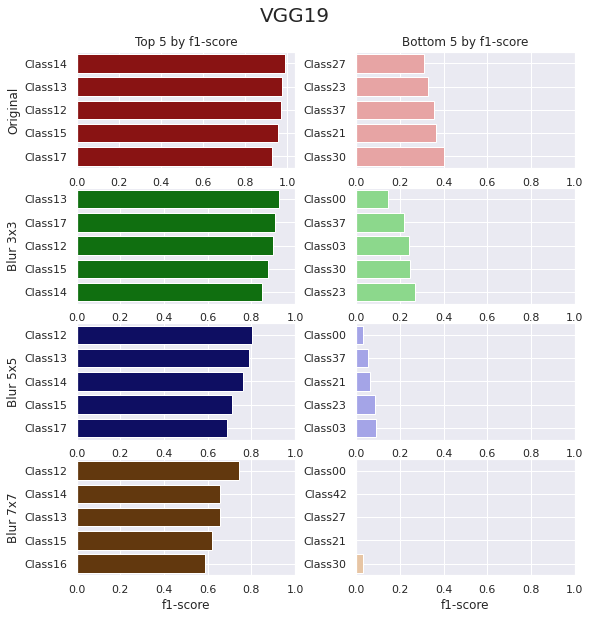

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
# plt.title("Yoooo", fontsize = 28, loc='center')

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
# ax[0,0].get_xaxis().set_visible(False)
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
# ax[0,1].get_xaxis().set_visible(False)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
# ax[0,1].get_yaxis().set_visible(False)
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
# ax[1,0].get_xaxis().set_visible(False)
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
# ax[1,1].get_xaxis().set_visible(False)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)
# ax[1,1].get_yaxis().set_visible(False)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
# ax[2,0].get_xaxis().set_visible(False)
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
# ax[2,1].get_xaxis().set_visible(False)
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)
# ax[2,1].get_yaxis().set_visible(False)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=vgg_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)
# ax[3,1].get_yaxis().set_visible(False)

fig.tight_layout(pad=0)
fig.suptitle('VGG19', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'VGG19_f1_scores.png'), 
            dpi=300, bbox_inches='tight')

In [ ]:
loss, acc = vgg_new_model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

In [ ]:
score = vgg_new_model.evaluate(X_test, y_test, verbose=1)

print(score)

In [ ]:
# Saving the model
vgg_new_model.save('vgg_new_model.h5')

In [ ]:
print('TensoFlow Version: ', tf.__version__)

TensoFlow Version:  2.2.0


In [ ]:
del vgg_model, vgg_new_model

In [ ]:
gc.collect()

10014